# Import needed modules and useful functions

In [1]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

### Notes
Starting from the basin B it is possible to escape from the local minima within 35ns  
While starting from basin A it is possible to escape within 15550 ns

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#
print(kb*300)

2.4942


# Prepare input files for plumed

In [3]:
folder = "unbias_A/bias1_tica/"
#Path(folder).mkdir(parents=True, exist_ok=True)

input_file = "input.sA.tpr" # input.sA.tpr
Time = 2 #5 ns non serve così tanto.. farò con 2
#-- run gromacs --#
execute("cp script/input.ala2.pdb script/"+input_file+" script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")
execute("sed -i '0,/ns/s/ns.*/ns="+str(Time)+"/' run_gromacs.sh",folder=folder)
execute("sed -i '0,/tprfile/s/tprfile.*/tprfile="+input_file+"/' run_gromacs.sh",folder=folder)
execute("./run_gromacs.sh",folder=folder)

Completed: cp script/input.ala2.pdb script/input.sA.tpr script/plumed_descriptors.data script/run_gromacs.sh unbias_A/bias1_tica/
Completed: sed -i '0,/ns/s/ns.*/ns=2/' run_gromacs.sh
Completed: sed -i '0,/tprfile/s/tprfile.*/tprfile=input.sA.tpr/' run_gromacs.sh
Completed: ./run_gromacs.sh


   time      phi      psi       ene        d1        d2        d3        d4  \
0   0.0 -2.36867  2.64432 -41.45830  0.152064  0.233505  0.241173  0.379827   
1   0.2 -2.02950  2.10255 -27.71580  0.155034  0.240890  0.247823  0.389504   
2   0.4 -1.15589  2.54488  -4.89294  0.153027  0.234942  0.243231  0.374957   
3   0.6 -1.61174  2.14733 -15.06590  0.159478  0.246002  0.254209  0.392069   
4   0.8 -1.63514  2.11999  -6.21399  0.148228  0.234663  0.234651  0.374927   

         d5        d6  ...       d43       d44       d45  tica_cv1_0  \
0  0.473298  0.464863  ...  0.227324  0.281913  0.148169   -0.001458   
1  0.460840  0.488095  ...  0.224882  0.278018  0.147995   -0.000686   
2  0.480068  0.418101  ...  0.231896  0.299416  0.149966   -0.001381   
3  0.487703  0.483904  ...  0.226211  0.290723  0.151924   -0.000534   
4  0.476928  0.424462  ...  0.225252  0.267515  0.143906   -0.000679   

   tica_cv2_0  opes.bias  opes.rct  opes.zed  opes.neff  opes.nker  
0   -0.000044      -40.

Text(0, 0.5, '$\\psi$')

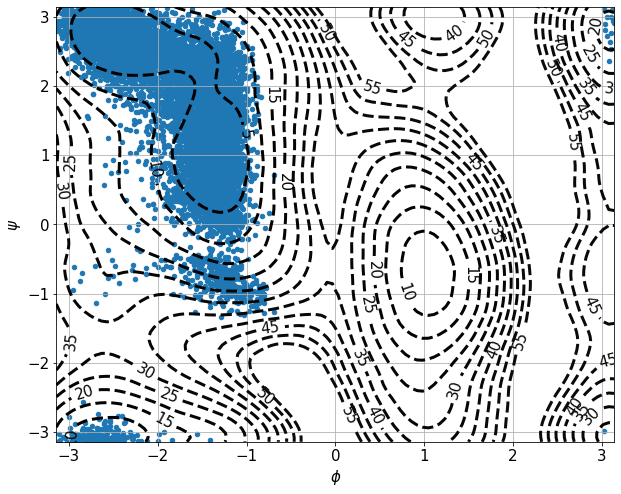

In [4]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
data = load_dataframe(folder+"COLVAR")
data.plot.scatter(y="psi",x="phi",ax=ax)
print(data.head())

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

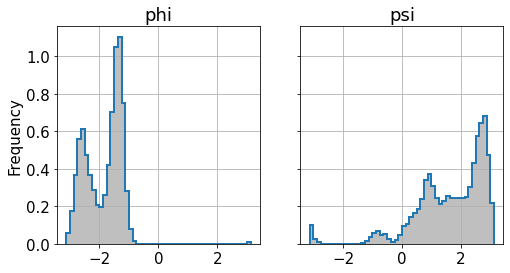

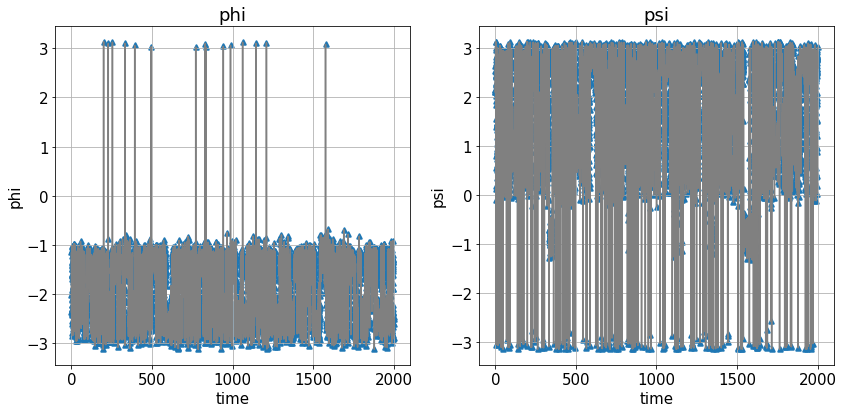

In [5]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::1].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::1].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

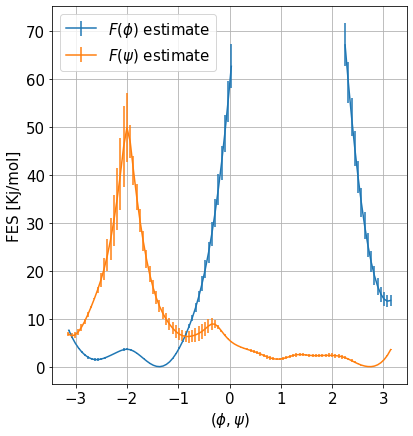

In [6]:
#-- estimation of Free Energy Surface --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend([r"$F(\phi)$ estimate",r"$F(\psi)$ estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(\phi,\psi)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

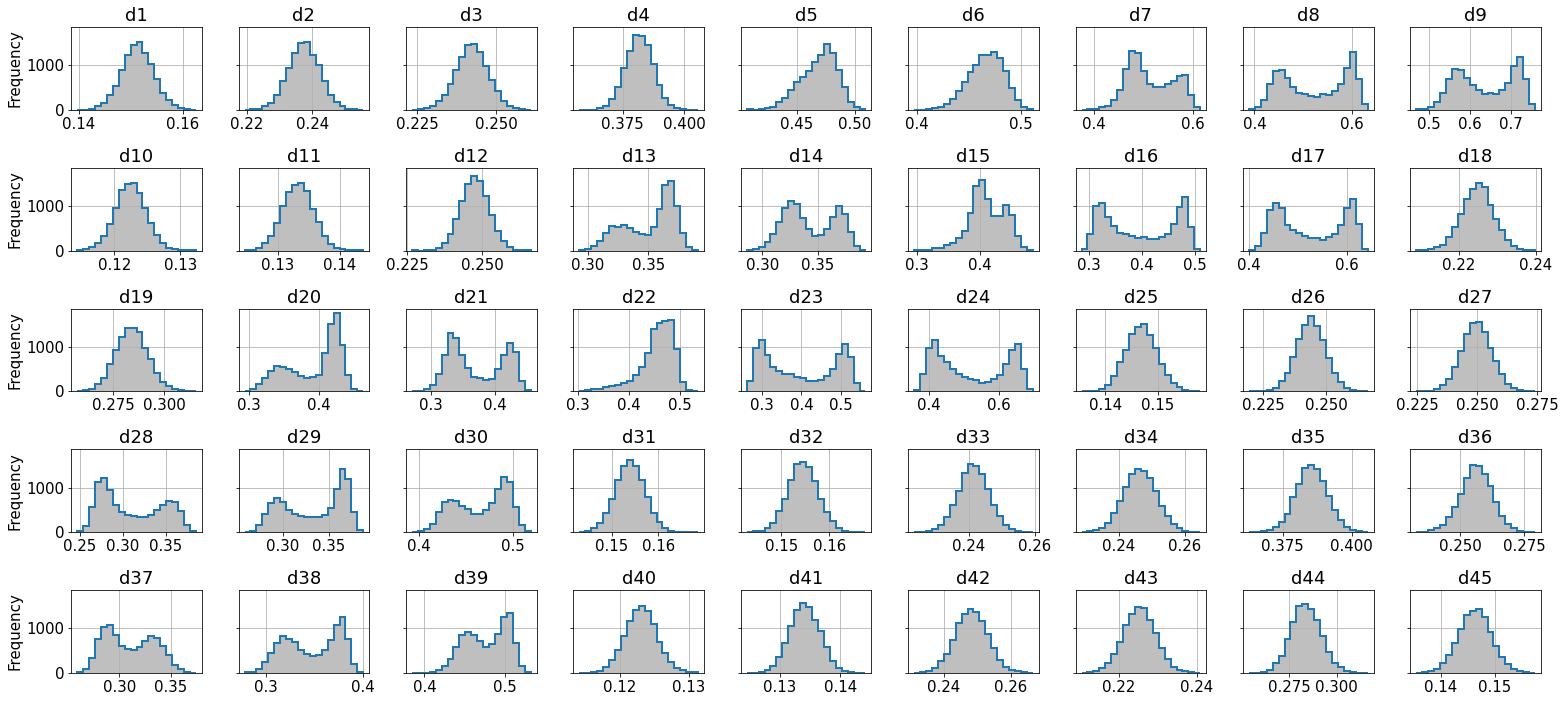

In [7]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

fig,axs = plt.subplots(5,9,figsize=(22,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=20,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2)#,density=True)
    data[desc].plot.hist(bins=20,alpha=0.5,ax=ax,legend=False,grid=True,color="grey")#,density=True)
    ax.set_title(desc)

plt.tight_layout()

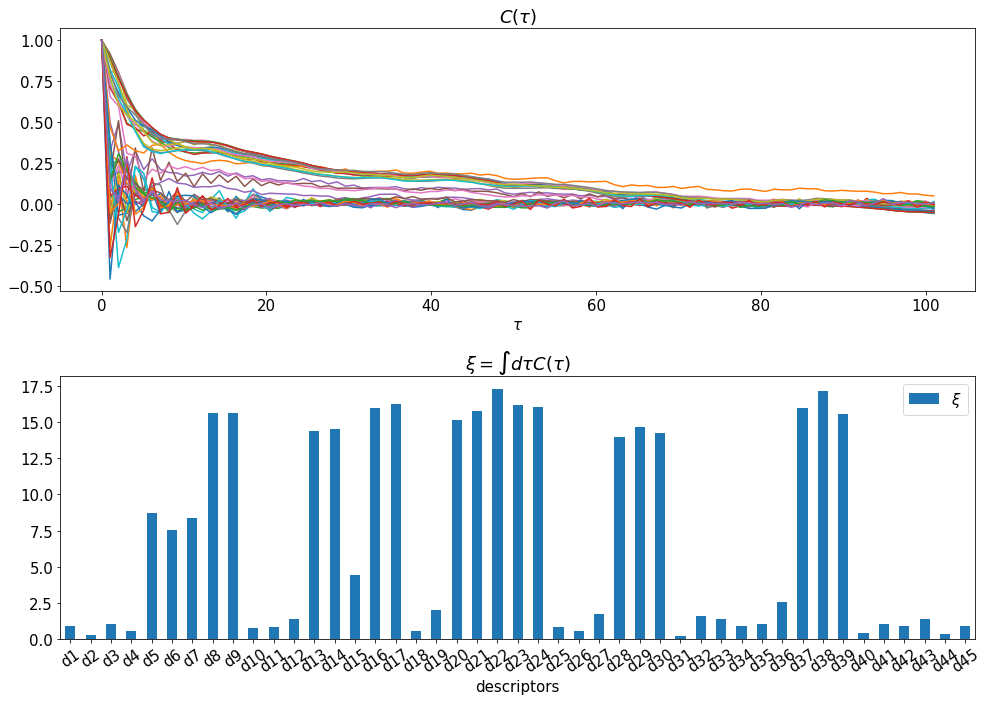

17.292996310177625
0.19958251799719734


In [8]:
fig,axs = plt.subplots(2,1,figsize=(14,10))#,sharey=True)

#-- in ps --#
last=100
x = np.linspace(0,last+1,last)
acorr = np.empty(last)
timescale = np.empty(len(descriptors_names))
k=0
for desc in descriptors_names:
    #print("autocorrelation for ", desc)
    for i in range(last):
        acorr[i] = data[desc].autocorr(i)
    axs[0].plot(x,acorr)
    timescale[k] = integrate.trapz(acorr[:last],x[:last])
    k+=1

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=axs[1],fontsize=15,label=r"$\xi$")

axs[0].set_xlabel(r'$\tau$')
axs[0].set_title(r'$C(\tau)$')
axs[1].set_title(r'$\xi=\int d\tau C(\tau)$')

plt.tight_layout()
plt.show()

print(np.max(timescale))
print(np.min(timescale))

#fit_timeacorr(descriptors_names,data,axs=None)

## DeepTICA Analysis and Export

In [9]:
min_lag,max_lag = 0.2,5 
n = 5 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
print(lags)
shuffle = False # if shuffle the data between batches
#-- train_datasets and valid_datasets list, it will be filled with new data every iteration
train_datasets = []
valid_datasets = []
# torch seed 
torch.manual_seed(21)

descriptors_names = data.filter(regex='^d[^a-z]').columns.values

#-- TRAINING PARAMETERS --#
n_output = 2 # 2 non linear combination of the descriptors  
n_input = len(descriptors_names) # can change..
train_parameters = {
              'descriptors': '^d[^a-z]', # can change during simulation
              'nodes':[n_input,30,30,n_output],
              'activ_type': 'tanh',#'relu','selu','tanh'
              'lag_time':10, 
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7, 
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':600,
              'batchsize': -1, #---> è da fare sul train loder and valid loader
              'es_patience':10,
              'es_consecutive':True,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              }

# how many data in single batch, batchsize
n_train = int( len(data)*train_parameters["trainsize"] )
n_valid = int( len(data)*(1-train_parameters["trainsize"])-int(10*max_lag) )
print("training samples: ",n_train, "\t validation samples", n_valid)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = data['time'].values
X = data[descriptors_names].values

[0.2 1.4 2.6 3.8 5. ]
training samples:  7000 	 validation samples 2950


In [10]:
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,lag_time=np.round(lag,3),interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.001,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.864      -0.830      0.446  0.228  
100   -1.172      -1.135      0.652  0.249  
150   -1.232      -1.174      0.680  0.261  
200   -1.271      -1.188      0.702  0.272  
INFO: Early stopping
239   -1.293      -1.195      0.713  0.280  


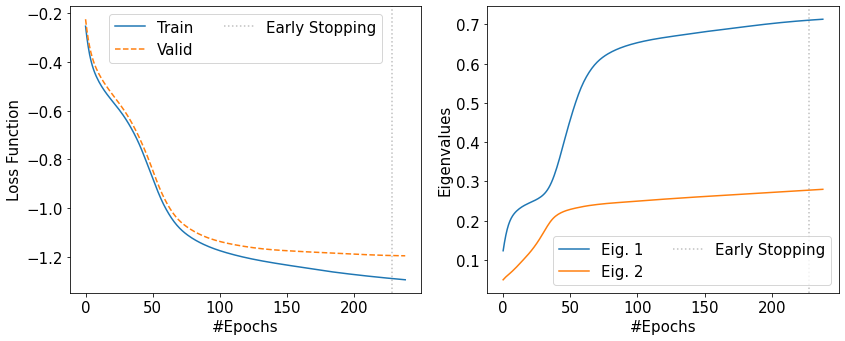

In [11]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [12]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

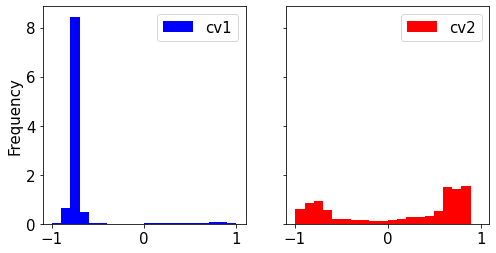

In [13]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

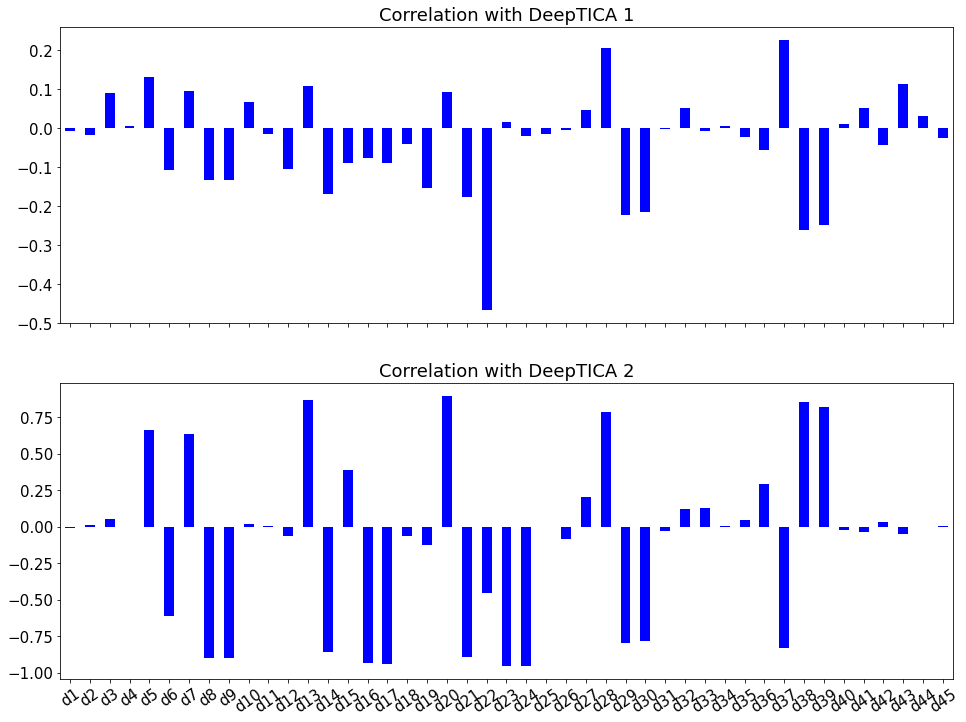

In [14]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

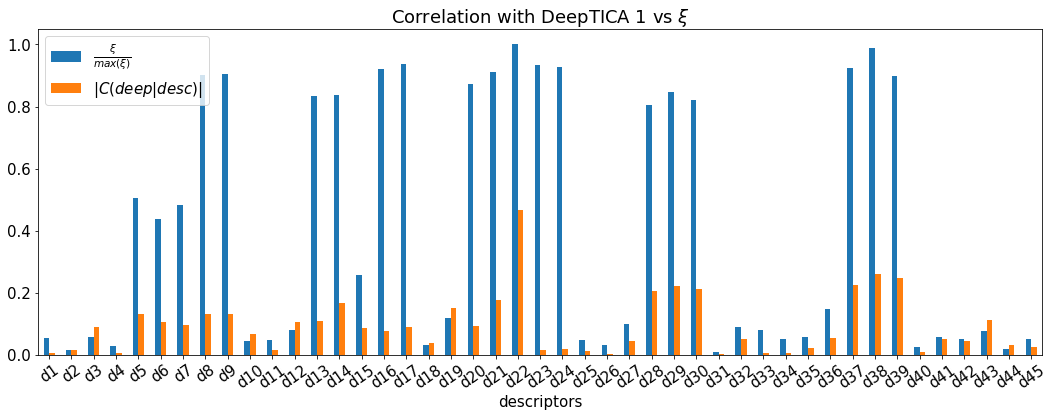

In [15]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
times["timescale"] = times["timescale"]/np.max(times["timescale"])
cols = ["cv1"]
cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
corr = data[cols].corr(method='pearson')
times["corr"] = np.abs(corr["cv1"].to_numpy()[1:])
times.plot(kind="bar",x="descriptors",rot=35,ax=ax,fontsize=15,stacked=False)
ax.set_title(r'Correlation with DeepTICA 1 vs $\xi$')
ax.legend([r"$\frac{\xi}{max(\xi)}$",r"$|C(deep|desc)|$"])
plt.show()

### FES estimate from cvs  
Obviously from this first simulation it is not possible to found a cvs that from data are able to distinguish all the possible basins. I recall that our approach is a **data drive approach**.  


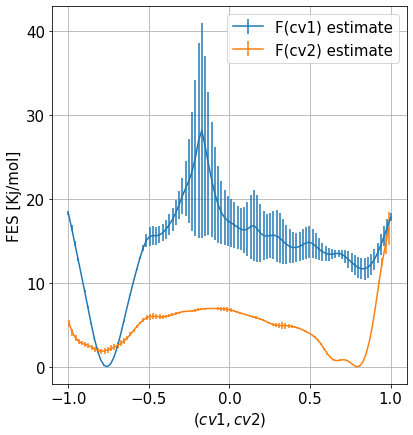

In [16]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

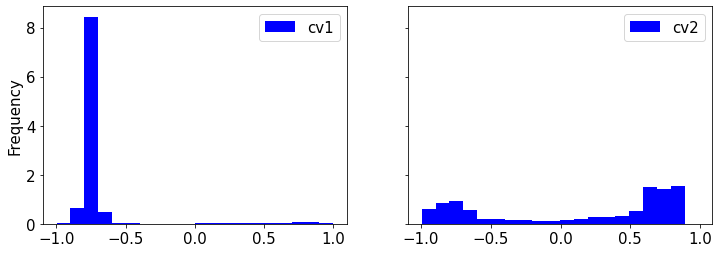

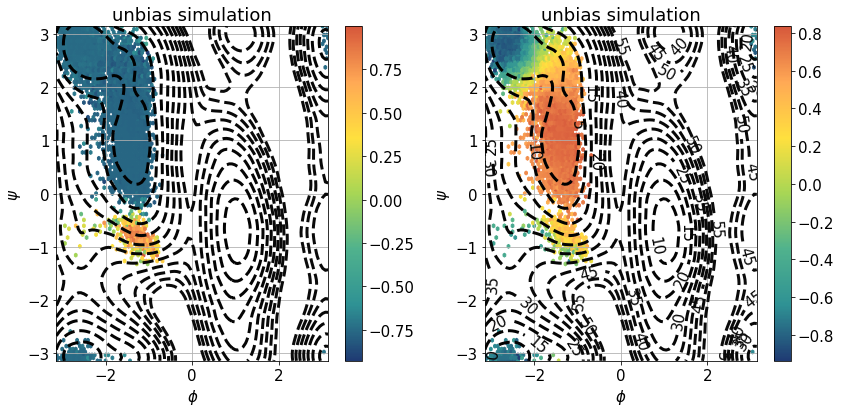

In [17]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b")

fig,ax = plt.subplots(1,2,figsize=(12,6))
data.plot.hexbin(y="psi",x="phi",C="cv1",cmap="fessa",ax=ax[0])#,ax=axs[k])
data.plot.hexbin(y="psi",x="phi",C="cv2",cmap="fessa",ax=ax[1])

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_title("unbias simulation")
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_title("unbias simulation")
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")
plt.tight_layout()

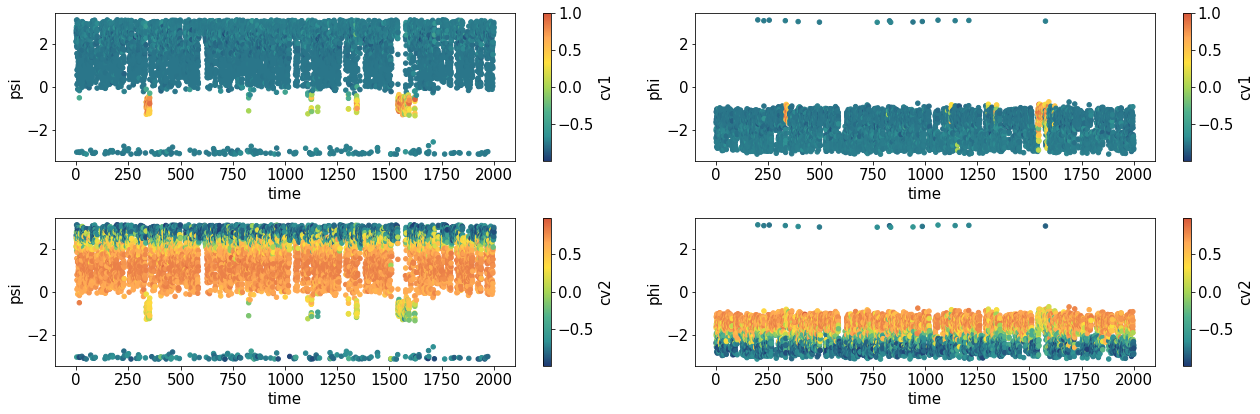

In [18]:
fig,axs = plt.subplots(2,2,figsize=(18,6))
data.plot.scatter(x="time",y="psi",c="cv1",cmap="fessa",ax=axs[0][0])
data.plot.scatter(x="time",y="phi",c="cv1",cmap="fessa",ax=axs[0][1])
data.plot.scatter(x="time",y="psi",c="cv2",cmap="fessa",ax=axs[1][0])
data.plot.scatter(x="time",y="phi",c="cv2",cmap="fessa",ax=axs[1][1])

plt.tight_layout()

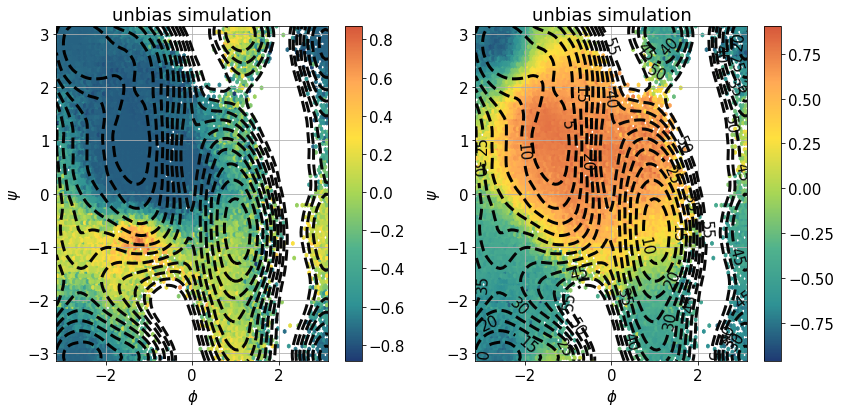

In [19]:
data_complete = load_dataframe("angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy() 
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]   

fig,ax = plt.subplots(1,2,figsize=(12,6))
data_complete.plot.hexbin(y="psi",x="phi",C="cv1",cmap="fessa",ax=ax[0])#,ax=axs[k])
data_complete.plot.hexbin(y="psi",x="phi",C="cv2",cmap="fessa",ax=ax[1])

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_title("unbias simulation")
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_title("unbias simulation")
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")
plt.tight_layout()

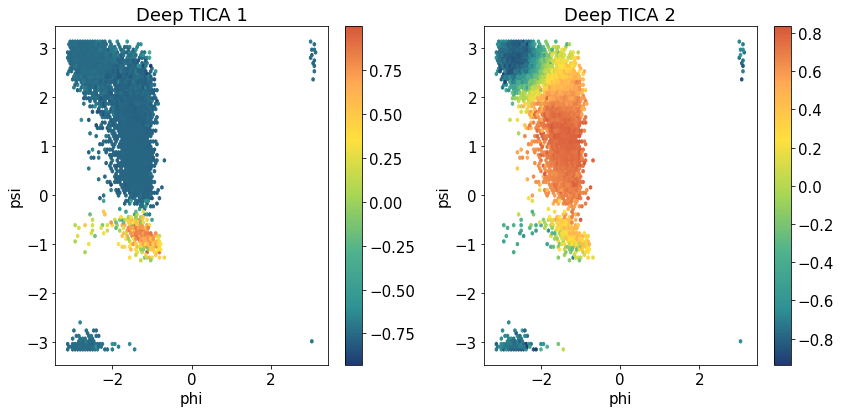

In [20]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.hexbin(y="psi",x="phi",C="cv"+str(k+1),cmap="fessa",ax=ax)
    ax.set_title('Deep TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [21]:
Boltzmann_product(model,model,X,j=0,k=1)

-0.08599031294997818

# TICA

In [22]:
# MODEL
tica = TICA_CV(n_features=X.shape[1])
tica.to(device)
#tica.tica.symmetrize = False
t = data['time'].values
X = data[descriptors_names].values

In [23]:
# TRAIN
tica.fit(X, t, lag=1)

tica.to("cpu")
feature_names = data[descriptors_names].columns.values
tica.set_params({"feature_names": feature_names})
#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",tica.tica.evals_.detach().cpu().numpy())

print(tica.plumed_input().splitlines()[:2])
print(tica.plumed_input().splitlines()[0][8:])

eigenvalues:  [ 0.7970533   0.5469353   0.30027828  0.2558927   0.23237643  0.21743473
  0.20244664  0.17687449  0.1692784   0.15511392  0.1483237   0.13752203
  0.11994525  0.09813754  0.08970065  0.08397479  0.06983493  0.06528947
  0.0618379   0.05227077  0.04145981  0.03903173  0.03106544  0.02624106
  0.02091878  0.01504889  0.00896127 -0.00809929 -0.01295759 -0.01681891
 -0.01906491 -0.03166949 -0.04327244 -0.06366937 -0.0686482  -0.09019974
 -0.09676855 -0.12201525 -0.13466966 -0.14411062 -0.15201855 -0.2170559
 -0.22435953 -0.33978516 -0.4365035 ]
['tica_cv1: CUSTOM ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45 VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44 FUNC=0.015079*(x0-0.151327)-0.017751*(x1-0.237393)-0.001899*(x2-0.2423

In [24]:
data["cv1_tica"] = np.transpose(tica(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2_tica"] = np.transpose(tica(torch.Tensor(X)).detach().cpu().numpy())[1] 

<AxesSubplot:ylabel='Frequency'>

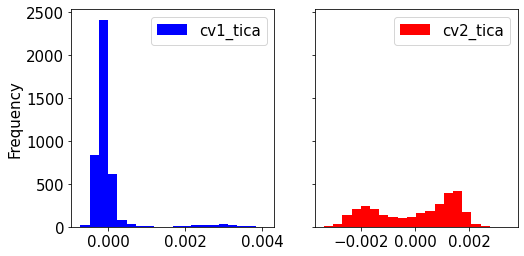

In [25]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1_tica",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2_tica",bins=20,ax=axs[1],density=True,color="r")

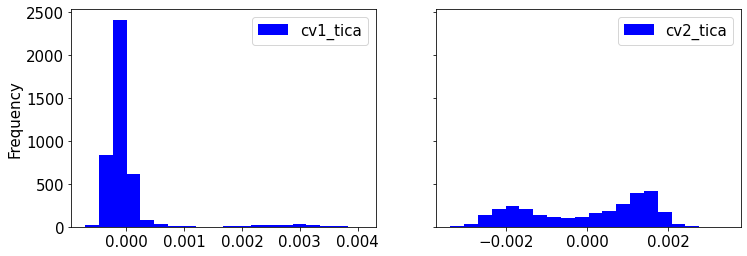

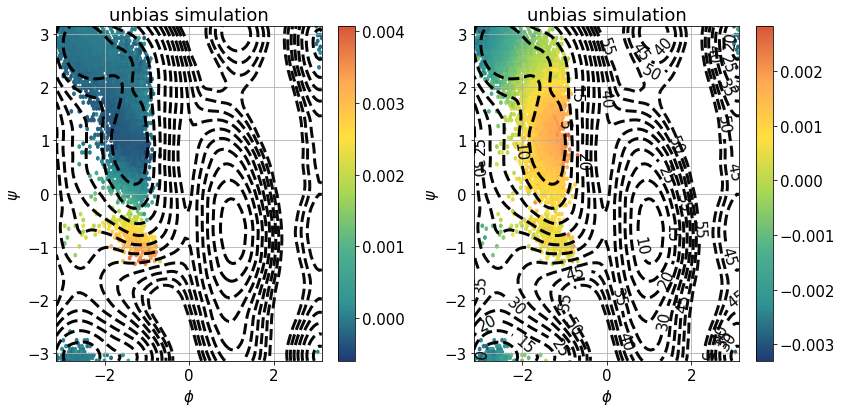

In [26]:
fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=True)
data.plot.hist(y="cv1_tica",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2_tica",bins=20,ax=axs[1],density=True,color="b")

fig,ax = plt.subplots(1,2,figsize=(12,6))
data.plot.hexbin(y="psi",x="phi",C="cv1_tica",cmap="fessa",ax=ax[0])#,ax=axs[k])
data.plot.hexbin(y="psi",x="phi",C="cv2_tica",cmap="fessa",ax=ax[1])

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_title("unbias simulation")
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_title("unbias simulation")
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")
plt.tight_layout()

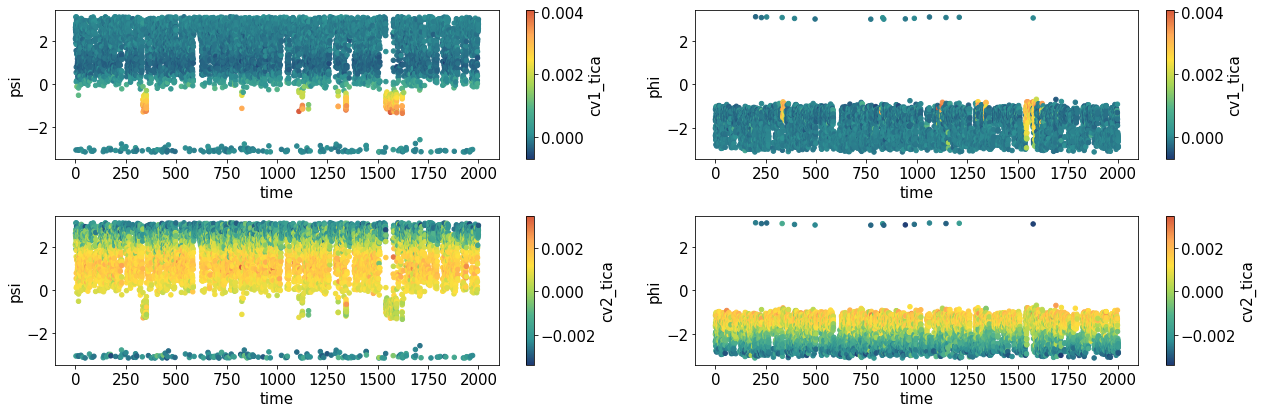

In [27]:
fig,axs = plt.subplots(2,2,figsize=(18,6))
data.plot.scatter(x="time",y="psi",c="cv1_tica",cmap="fessa",ax=axs[0][0])
data.plot.scatter(x="time",y="phi",c="cv1_tica",cmap="fessa",ax=axs[0][1])
data.plot.scatter(x="time",y="psi",c="cv2_tica",cmap="fessa",ax=axs[1][0])
data.plot.scatter(x="time",y="phi",c="cv2_tica",cmap="fessa",ax=axs[1][1])

plt.tight_layout()

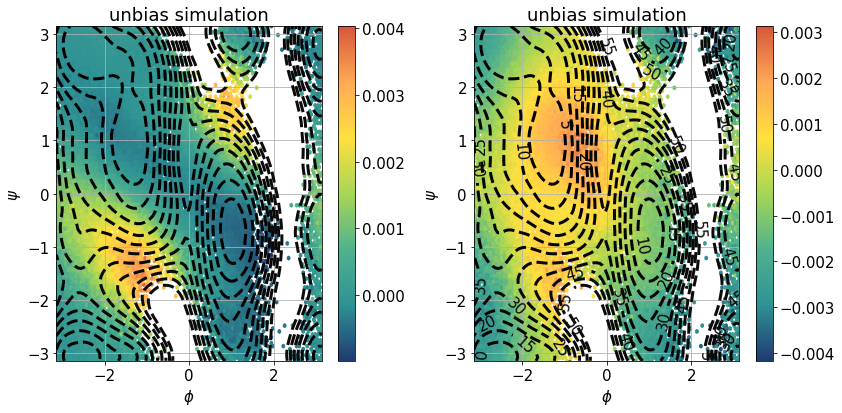

In [28]:
data_complete = load_dataframe("angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy() 
data_complete["cv1_tica"] = np.transpose(tica(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2_tica"] = np.transpose(tica(torch.Tensor(X_complete)).detach().cpu().numpy())[1]   

fig,ax = plt.subplots(1,2,figsize=(12,6))
data_complete.plot.hexbin(y="psi",x="phi",C="cv1_tica",cmap="fessa",ax=ax[0])#,ax=axs[k])
data_complete.plot.hexbin(y="psi",x="phi",C="cv2_tica",cmap="fessa",ax=ax[1])

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_title("unbias simulation")
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_title("unbias simulation")
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")
plt.tight_layout()

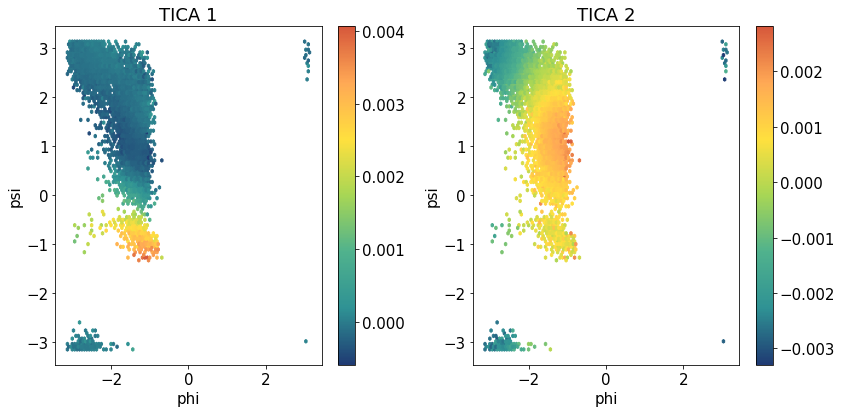

In [29]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.hexbin(y="psi",x="phi",C="cv"+str(k+1)+"_tica",cmap="fessa",ax=ax)
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()

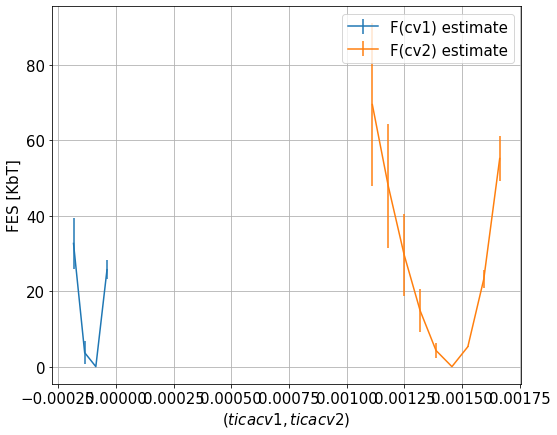

In [30]:
#-- estimation of Free Energy Surface --#
s = data[["cv1_tica","cv2_tica"]].to_numpy()#data.filter(regex="tica").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(8,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(tica cv1,tica cv2)$")
ax.set_ylabel("FES [KbT]")

plt.show()